In [1]:

import torch
import torch.nn as nn
from torch.nn import functional as F 

In [2]:
import math 
import numpy as np 

In [3]:

# Hyper parameters:
device = torch.cuda.is_available() if  "gpu" else "cpu"

d_model = 512
num_heads = 8
drop_prob = 0.1
batch_size = 30
max_sqeuence_length = 200 # overall 200 token:
ffn_hidden = 2048 # ffn-> feed forward netowrk's nuron
num_layer = 6



In [4]:

""" 
*************************************
Self Attention + MultiHeadAttention:
*************************************
"""



' \n*************************************\nSelf Attention + MultiHeadAttention:\n*************************************\n'

In [5]:
import numpy as np 
x = np.ones(shape=(30,200,512),dtype=np.float32)
y = torch.from_numpy(x)

In [6]:

# size of the tensor y:
y.size()


torch.Size([30, 200, 512])

In [7]:

# transpose of y:
# but problem is 30 is our batch dimention we need only trnaspose the 1st two column
# for that we can do:
print("orginal: ",y.size())
print("after transpose:", y.T.size())
print(y.transpose(dim0=-1,dim1=-2).size())


orginal:  torch.Size([30, 200, 512])
after transpose: torch.Size([512, 200, 30])
torch.Size([30, 512, 200])


/tmp/ipykernel_5034/2642397459.py:5: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4413.)
  print("after transpose:", y.T.size())


In [8]:

# why scaling?
# matmul() will give us high variance 
# softmax behavior on high variance data:
q = torch.randn(size=(4,4))
k = torch.randn(size=(4,4))
d_k = k.size()[-1]
print(q.var(),k.var(),torch.matmul(q,k.T).var())
scaled = torch.matmul(k,q.T) / math.sqrt(d_k)
print(k.var(),q.var(),scaled.var())


tensor(0.5325) tensor(0.5545) tensor(0.4697)
tensor(0.5545) tensor(0.5325) tensor(0.1174)


In [9]:
""" 
Musking while inference time: 
"""
mask = torch.tril(input=torch.from_numpy(np.ones(shape=(4,4))))
print(mask)
mask[mask==0] = -np.inf
mask[mask==1] = 0
print(mask,end="\n\n")
print(scaled+mask)
soft = nn.Softmax(dim=-1)
""" 
We know, softmax give us probability,
see the result of [0,0] it should give us 1, 
means that, it will foucus 100% to generate the 1st word,
for 2nd word,
63% and 37%
"""
soft(scaled+mask)


tensor([[1., 0., 0., 0.],
        [1., 1., 0., 0.],
        [1., 1., 1., 0.],
        [1., 1., 1., 1.]], dtype=torch.float64)
tensor([[0., -inf, -inf, -inf],
        [0., 0., -inf, -inf],
        [0., 0., 0., -inf],
        [0., 0., 0., 0.]], dtype=torch.float64)

tensor([[-0.0531,    -inf,    -inf,    -inf],
        [ 0.3997, -0.4233,    -inf,    -inf],
        [ 0.4605, -0.5080,  0.2511,    -inf],
        [ 0.2768, -0.2240,  0.0650, -0.3708]], dtype=torch.float64)


tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.6949, 0.3051, 0.0000, 0.0000],
        [0.4565, 0.1733, 0.3702, 0.0000],
        [0.3403, 0.2062, 0.2754, 0.1781]], dtype=torch.float64)

In [10]:

""" 
Self attention:
attention(Q,K,V) = softmax(QK^T/root(Dk)) * V
"""

def selfAttention(q,k,v,mask=None):
    """
    Compute scaled dot-product attention
    Args:
        q: queries of shape (batch, heads, seq_len, d_k)
        k: keys of shape    (batch, heads, seq_len, d_k)
        v: values of shape  (batch, heads, seq_len, d_k)
        mask: optional mask of shape (batch, 1, seq_len, seq_len)
    Returns:
        output: attended values (batch, heads, seq_len, d_k)
        attn: attention weights (batch, heads, seq_len, seq_len)
    """
    #30 X 8 X 200 X 64
    d_k = k.size()[-1] # 64
    #  q(30X8X200X64) k.T(30X8X64X200) 
    # this is a batch multiplication, so 30X8 will remain same
    # 200X64 64X200 = 200X200
    scaled = torch.matmul(q,k.transpose(-1,-2)) / math.sqrt(d_k) # 30X8X200X200
    if mask is not None:
        scaled += mask # pytoch is very smart, it will automatically determine shpae and add mask(200X200)
    attention = F.softmax(input=scaled,dim=-1)
    # S(30X8X200X200) V(30X8X200X64)
    # 30 X 8 X 200 X 64 
    values = torch.matmul(scaled,v) 
    return values,attention

    

In [11]:
# how multihead-attention is worked:
number_of_head = 8
d_model = 512
batch_size = 1
maximum_sequence_length = 4 
input_dim = 512
x = torch.randn(size=(batch_size,maximum_sequence_length,input_dim))
x.shape


torch.Size([1, 4, 512])

In [12]:

# we compute q,k,v into one matrix:
qkv = nn.Linear(in_features=input_dim,out_features=3*d_model)


In [13]:

""" 
***
MultiHeadAttention:
Slightly different from my note:
- Result of single attention will not stack along row.
- Meanwhile, we keep the embedding_dim = 512, divide then with the numbe of head
    - if our head is 8
        then, 512/8 = 64, 
        we will add, 8 head of dimention = 64
        And finally for linear transformation will will have, 512X512 dimention matrix
- For finding, q,k,v the matrix Wq,Wk,Wv we be stored into another matrix.

***
"""

class MultiHeadAttention(nn.Module):
    def __init__(self,d_model,num_heads):
        """
        Multi-Head Attention module
        Args:
            d_model: total embedding dimension
            num_heads: number of attention heads
        """
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        # must be devide by num_heads from our above condition:
        # assert d_model%num_heads == 0 
        self.head_dim = d_model // num_heads # 512/8 = 64 
        self.qkv = nn.Linear(in_features=d_model,out_features=3*d_model) # 512* 1536
        self.linear_trans = nn.Linear(in_features=d_model,out_features=d_model)
        
    def forward(self,x,mask=None):
            """ 
            In my simple multi-head attention diagram, we took input as 2X4 for a single word, (batch_size,embedding_size)
            But, In reality, we, will also consider batchsize,
            so the input should be, (batch_size,max_sequence_length)
            For,example 2 sentence, : 
                Batch 0 (“Hi ! my name is yasin .”):
                ┌───────────────────────────────────────────┐
                │ pos=0: e("Hi")    → [0.1, 0.2, 0.3, 0.4] │
                │ pos=1: e("!")     → [0.5, 0.6, 0.7, 0.8] │
                │ pos=2: e("my")    → [0.2, 0.1, 0.4, 0.3] │
                │ pos=3: e("name")  → [0.3, 0.8, 0.1, 0.9] │
                │ pos=4: e("is")    → [0.6, 0.2, 0.2, 0.5] │
                │ pos=5: e("yasin") → [0.9, 0.4, 0.7, 0.1] │
                │ pos=6: e(".")     → [0.0, 0.0, 0.0, 0.0] │ ← (padding) 
                └───────────────────────────────────────────┘

                Batch 1 (“I am fine .”):
                ┌───────────────────────────────────────────┐
                │ pos=0: e("I")     → [0.2, 0.3, 0.5, 0.7] │
                │ pos=1: e("am")    → [0.1, 0.4, 0.6, 0.8] │
                │ pos=2: e("fine")  → [0.3, 0.2, 0.9, 0.5] │
                │ pos=3: e(".")     → [0.0, 0.0, 0.0, 0.0] │ ← (padding)
                │ pos=4: PAD        → [0.0, 0.0, 0.0, 0.0] │
                │ pos=5: PAD        → [0.0, 0.0, 0.0, 0.0] │
                │ pos=6: PAD        → [0.0, 0.0, 0.0, 0.0] │
                └───────────────────────────────────────────┘
                Here, our maximum_sequence_length is 7.If we feed a sentece where 
                we give sequence_length is greater than 7 then we will get error.
                 ব্যাচ সাইজ (Batch Size)

                **ট্রেনিং-এ**: একসাথে N টি আলাদা “ট্রেনিং উদাহরণ” (conversations বা প্রশ্ন–উত্তর জোড়া) নিয়ে আমরা একটানা 
                প্রসেস করি।

                **ইনফারেন্স-এ**: সাধারণত batch_size=1 (একজন ব্যবহারকারীর বর্তমান চ্যাট history) বা সামগ্রিক সার্ভিসে 
                ধরো M জন ব্যবহারকারীর অনুরোধ একসঙ্গে।
            """
            batch_size,sequence_length, d_model = x.size() # 30x200x512
            qkv = self.qkv(x) # 30X200X1536
            qkv = qkv.view(batch_size,sequence_length,self.num_heads,3*self.head_dim) # 30X200X8X(64*3)=192
            qkv = qkv.permute(0,2,1,3) #30,8,200,192
            q,k,v = qkv.chunk(3,dim=-1) #30X8X200X64
            # value=30X8X200X64,  atten=30X8X200X200
            values,attention = selfAttention(q=q,k=k,v=v,mask=None)
            """ 
            -   permute() অপারেশন টেন্সরকে non-contiguous করে দেয়,
            -   PyTorch-এর view() মেথড শুধুমাত্র contiguous টেন্সরে কাজ করে view() ব্যর্থ হয় 
            -   after appling permute() টেন্সর এখন মেমরিতে "ভাঙা" অবস্থায় আছে (non-contiguous)
            -   view() চায় সব ডাটা একটানা মেমরি ব্লকে থাকুক

            সমাধান:
                reshape() ব্যবহার করুন (যা স্বয়ংক্রিয়ভাবে contiguity হ্যান্ডল করে):
            """
            values = values.permute(0, 2, 1, 3).reshape(batch_size,sequence_length,self.num_heads*self.head_dim) # [30, 200, 8, 64]
            #concatenate result, 30 x 200 X (head*head_dimeantion)
            #values.reshape(batch_size,sequence_length,self.num_heads*self.head_dim)
            # send concatenate result into final liner transformation layer
            out = self.linear_trans(values)
            return out
        
            
        

In [14]:

""" 
math.sqrt((x+y)), are applicable when, x,y both are integer,
(x+y).sqrt(), are applicable when, x,y both are tensor
"""

try: 
    x = 5
    y = 20
    print(math.sqrt((x+y)))
    print((x+y).sqrt())
except  Exception as  e:
    print(str(e))
    
try: 
    x = torch.randn(size=(3,3))
    y = torch.randn(size=(3,3))
    print((x+y).sqrt())
    print(math.sqrt((x+y)))
except Exception as e:
    print(str(e))
    

    

5.0
'int' object has no attribute 'sqrt'
tensor([[   nan,    nan, 1.0303],
        [0.8882, 1.1230, 1.7718],
        [   nan, 1.2271, 0.5830]])
only one element tensors can be converted to Python scalars


In [15]:

""" 
***
LayerNormalization:
***
"""

class LayerNormalization(nn.Module):
    # eps is epsilon, a small number. If std = 0, it will help from 
    # undefine value for (1/0) error.
    def __init__(self,parameters_shape,esp=1e-5):
        super().__init__()
        self.parameters_shape = parameters_shape # 512 
        self.esp = esp 
        # initially, gamma=1,beta=0
        # because,
        #  N = gamma*() + beta*()
        # If no normalazation is need this in this case
        # gamma =1 and beta =0 
        self.gamma = nn.Parameter(torch.ones(parameters_shape)) # 512
        self.beta = nn.Parameter(torch.zeros(parameters_shape)) # 512
        
    def forward(self,inputs): # input = (30 X 200 X 512)
        # we are appling layer normalization.
        dims = [-(i+1) for i in range(len(self.parameters_shape))] #[-0],[-1], like this,(30x200x1)
        mean = inputs.mean(dim=dims,keepdim=True) # 30 X 200 X 1
        var = ((inputs-mean) **2).mean(dim=dims,keepdim=True)  
        std = (var+self.esp).sqrt()
        y = (inputs-mean)/std # 30 X 200 X 512 
        """ 
        gamma and beta are learnable parameter, we will get
        (512X1) vector for both gamma and beta
        and it's should be equal to embedding dimention
        """
        out = self.gamma * y + self.beta 
        return out

In [16]:

""" 
***
FeedForwardNetwork:
From the paper: FFN(x) = max(0, xW1 + b1)W2 + b2, 
We don't need to relu layer after linear2.
***
"""
class FeedForwared(nn.Module):
    def __init__(self,d_model,hidden,drop_prob):
        super().__init__()
        self.linear1 = nn.Linear(in_features=d_model,out_features=hidden) # 512 X 2048
        self.linear2 = nn.Linear(in_features=hidden,out_features=d_model) # 2048 X 512
        self.relu = nn.ReLU()
        self.dropOut = nn.Dropout(p=drop_prob)
        
    def forward(self,x):
        x = self.linear1(x) # 30x200x512
        x = self.relu(x)
        x = self.dropOut(x)
        x = self.linear2(x) # 30x200x512
        return x


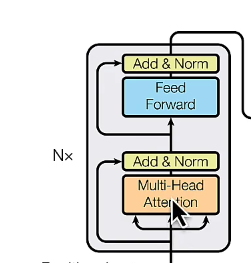

In [17]:
"""
Encoder Layer: 
"""
from IPython.display import Image,display
display(Image("img/img01.png"))

In [ ]:

class EncoderLayer(nn.Module):
    def __init__(self,d_model,ffn_hidden,num_heads,drop_prob):
        super(EncoderLayer,self).__init__()
        self.attention = MultiHeadAttention(d_model=d_model,num_heads=num_heads)
        # d model, is list because beta or gamma size should be tuple or list of int
        self.norm1 = LayerNormalization(parameters_shape=[d_model])
        self.dropout1 = nn.Dropout(p=drop_prob)
        self.ffn = FeedForwared(d_model=d_model,hidden=ffn_hidden,drop_prob=drop_prob)
        self.norm2 = LayerNormalization(parameters_shape=[d_model])
        self.dropout2 = nn.Dropout(p=drop_prob)
    def forward(self,x):
        residusl_x = x # 30 x 200 x 512
        x = self.attention(x,mask=None) # it will call the forward function (30 x 200 x 512)
        x = self.dropout1(x) # 30 x 200 x 512
        x = self.norm1(x+residusl_x) # 30 x 200 x 512
        residusl_x = x  # 30 x 200 x 512
        x = self.ffn(x) # 30 x 200 x 512
        x = self.dropout2(x) # 30 x 200 x 512
        x = self.norm2(x+residusl_x) # 30 x 200 x 512
        return x 

    

In [19]:


class Encoder(nn.Module):
    def __init__(self,d_model,ffn_hidden,num_heads,drop_prob,num_layer):
        super().__init__()
        self.layers = nn.Sequential(*[EncoderLayer(d_model,ffn_hidden,num_heads,drop_prob) for _ 
                                      in range(num_layer)])
    def forward(self,x):
        x = self.layers(x)
        return x
            
            


d_model = 512
num_heads = 8
drop_prob = 0.1
batch_size = 30
max_sequence_length = 200
ffn_hidden = 2048
num_layers = 5

encoder = Encoder(d_model, ffn_hidden, num_heads, drop_prob, num_layers)
     
x = torch.randn( (batch_size, max_sequence_length, d_model) )
out = encoder(x)
     

